# Distributed Model Selection and Assessment

Outline of the session:

- Introduction to **IPython.parallel**
- Sharing Data Between Processes with **Memory Mapping**
- **Parallel Grid Search** for Model Selection
- **Distributed** Computation on **EC2 Spot Instances with StarCluster**

## Motivation

When doing model evaluations and parameters tuning, many models must be trained independently on the same data. This is an embarrassingly parallel problem but having a copy of the dataset in memory for each process is waste of RAM.

When doing 3 folds cross validation on a 9 parameters grid, a naive implementation could read the data from the disk and load it in memory 27 times. If this happens concurrently (e.g. on a compute node with 32 cores) the RAM might blow up hence breaking the potential linear speed up.

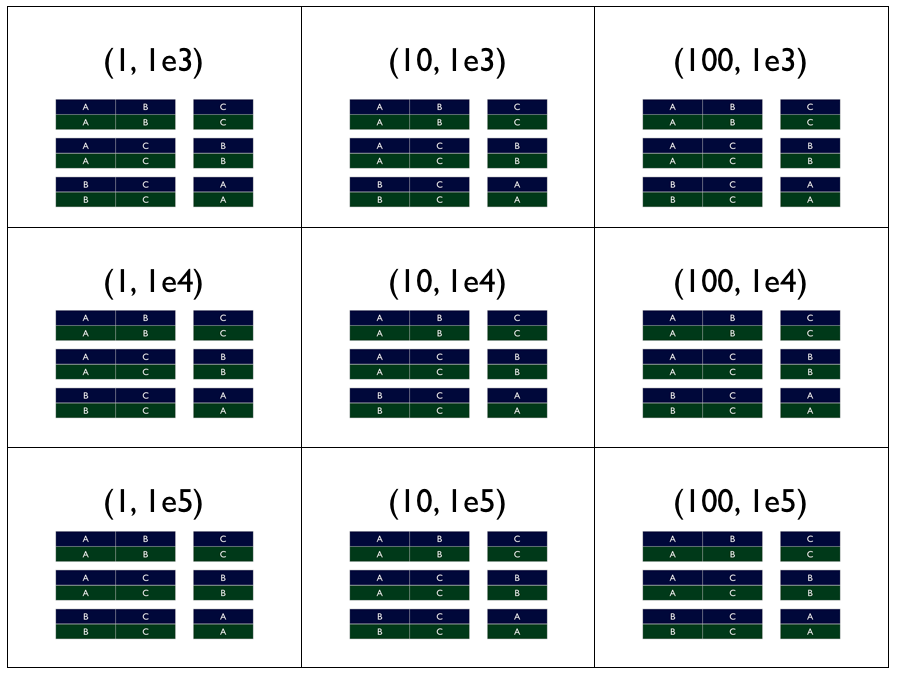

In [1]:
from IPython.core.display import Image, display
display(Image(filename='figures/grid_search_cv_splits.png'))

## IPython.parallel, a Primer

This section gives a primer on some tools best utilizing computational resources when doing predictive modeling in the Python / NumPy ecosystem namely:

- optimal usage of available CPUs and cluster nodes with **`IPython.parallel`**

- optimal memory re-use using shared memory between Python processes using **`numpy.memmap`** and **`joblib`**

### What is so great about `IPython.parallel`:

- Single node multi-CPUs
- Multiple node multi-CPUs
- Interactive In-memory computing
- IPython notebook integration with `%px` and `%%px` magics
- Possibility to interactively connect to individual computing processes to launch interactive debugger (`#priceless`)

### Let's get started:

Go to the "Cluster" tab of the notebook and **start a local cluster with 2 engines**. Then come back here:

In [2]:
from IPython.parallel import Client
client = Client()

/home/sasha/miniconda3/envs/sklearn_scipy2013/lib/python3.6/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


ModuleNotFoundError: No module named 'parallel'

In [ ]:
len(client)

#### The %px and %%px magics

All the engines of the client can be accessed imperatively using the `%px` and `%%px` IPython cell magics:

In [ ]:
%%px

import os
import socket

print("This is running in process with pid {0} on host '{1}'.".format(
      os.getpid(), socket.gethostname()))

The content of the `__main__` namespace can also be read and written via the `%px` magic:

In [ ]:
%px a = 1

In [ ]:
%px print(a)

In [ ]:
%%px

a *= 2
print(a)

It is possible to restrict the `%px` and `%%px` magic instructions to specific engines:

In [ ]:
%%px --targets=-1
a *= 2
print(a)

In [ ]:
%px print(a)

#### The DirectView objects

Cell magics are very nice to work interactively from the notebook but it's also possible to replicate their behavior programmatically with more flexibility with a `DirectView` instance. A `DirectView` can be created by slicing the client object:

In [ ]:
all_engines = client[:]
all_engines

The namespace of the `__main__` module of each running python engine can be accessed in read and write mode as a python dictionary:

In [ ]:
all_engines['a'] = 1

In [ ]:
all_engines['a']

Direct views can also execute the same code in parallel on each engine of the view:

In [ ]:
def my_sum(a, b):
    return a + b

my_sum_apply_results = all_engines.apply(my_sum, 11, 31)
my_sum_apply_results

The ouput of the `apply` method is an asynchronous handle returned immediately without waiting for the end of the computation. To block until the results are ready use:

In [ ]:
my_sum_apply_results.get()

Here is a more useful example to fetch the network hostname of each engine in the cluster. Let's study it in more details:

In [ ]:
def hostname():
    """Return the name of the host where the function is being called"""
    import socket
    return socket.gethostname()

hostname_apply_result = all_engines.apply(hostname)

When doing the above, the `hostname` function is first defined locally (the client python process). The `DirectView.apply` method introspects it, serializes its name and bytecode and ships it to each engine of the cluster where it is reconstructed as local function on each engine. This function is then called on each engine of the view with the optionally provided arguments.

In return, the client gets a python object that serves as an handle to asynchronously fetch the list of the results of the calls:

In [ ]:
hostname_apply_result

In [ ]:
hostname_apply_result.get()

It is also possible to key the results explicitly with the engine ids with the `AsyncResult.get_dict` method. This is a very simple idiom to fetch metadata on the runtime environment of each engine of the direct view:

In [ ]:
hostnames = hostname_apply_result.get_dict()
hostnames

It can be handy to invert this mapping to find one engine id per host in the cluster so as to execute host specific operation:

In [ ]:
one_engine_by_host = dict((hostname, engine_id) for engine_id, hostname
                      in hostnames.items())
one_engine_by_host

In [ ]:
one_engine_per_host_view = client[one_engine_by_host.values()]
one_engine_per_host_view

**Trick:** you can even use those engines ids to execute shell commands in parallel on each host of the cluster:

In [ ]:
one_engine_by_host.values()

In [ ]:
%%px --targets=[1]

!pip install flask

#### Note on Importing Modules on Remote Engines

In the previous example we put the `import socket` statement inside the body of the `hostname` function to make sure to make sure that is is available when the rest of the function is executed in the python processes of the remote engines.

Alternatively it is possible to import the required modules ahead of time on all the engines of a directview using a context manager / with syntax:

In [ ]:
with all_engines.sync_imports():
    import numpy

However this method does **not** support alternative import syntaxes:
    
    >>> import numpy as np
    >>> from numpy import linalg

Hence the method of importing in the body of the "applied" functions is more flexible. Additionally, this does not pollute the `__main__` namespace of the engines as it only impact the local namespace of the function itself.

**Exercise**:

- Write a function that returns the memory usage of each engine process in the cluster.
- Allocate a largish numpy array of zeros of known size (e.g. 100MB) on each engine of the cluster.

Hints:

Use the `psutil` module to collect the runtime info on a specific process or host. For instance to fetch the memory usage of the currently running process in MB:

    >>> import os
    >>> import psutil
    >>> psutil.Process(os.getpid()).get_memory_info().rss / 1e6

To allocate a numpy array with 1000 zeros stored as 64bit floats you can use:

    >>> import numpy as np
    >>> z = np.zeros(1000, dtype=np.float64)

The size in bytes of such a numpy array can then be fetched with ``z.nbytes``:
    
    >>> z.nbytes / 1e6
    0.008

In [ ]:
def get_engines_memory(client):
    def memory_mb():
        import os, psutil
        return psutil.Process(os.getpid()).get_memory_info().rss / 1e6
    
    return client[:].apply(memory_mb).get_dict()

In [ ]:
get_engines_memory(client)

In [ ]:
sum(get_engines_memory(client).values())

In [ ]:
%%px
import numpy as np
z = np.zeros(int(1e7), dtype=np.float64)
print("Allocated {0}MB on engine.".format(z.nbytes / 1e6))

In [ ]:
get_engines_memory(client)

#### Load Balanced View

`LoadBalancedView` is an alternative to the `DirectView` to run one function call at a time on a free engine.

In [ ]:
lv = client.load_balanced_view()

In [ ]:
def slow_square(x):
    import time
    time.sleep(2)
    return x ** 2

In [ ]:
result = lv.apply(slow_square, 4)

In [ ]:
result

In [ ]:
result.ready()

In [ ]:
result.get()  # blocking call

It is possible to spread some tasks among the engines of the LB view by passing a callable and an iterable of task arguments to the `LoadBalancedView.map` method:

In [ ]:
results = lv.map(slow_square, [0, 1, 2, 3])
results

In [ ]:
results.ready()

In [ ]:
results.progress

In [ ]:
# results.abort()

In [ ]:
# Iteration on AsyncMapResult is blocking
for r in results:
    print(r)

The load balanced view will be used in the following to schedule work on the cluster while being able to monitor progress and occasionally add new computing nodes to the cluster while computing to speed up the processing when using EC2 and StarCluster (see later).

## Sharing Read-only Data between Processes on the Same Host with Memmapping

Let's **restart the cluster** to kill the existing python processes and restart with a new client instances to be able to monitor the memory usage in details:

In [ ]:
from IPython.parallel import Client
client = Client()

The numpy package makes it possible to memory map large contiguous chunks of binary files as shared memory for all the Python processes running on a given host:

In [ ]:
%px import numpy as np

Creating a `numpy.memmap` instance with the `w+` mode creates a file on the filesystem and zeros its content. Let's do it from the first engine process or our current IPython cluster:

In [ ]:
%%px --targets=-1

# Cleanup any existing file from past session (necessary for windows)
import os
if os.path.exists('small.mmap'):
    os.unlink('small.mmap')

mm_w = np.memmap('small.mmap', shape=10, dtype=np.float32, mode='w+')
print(mm_w)

Assuming the notebook process was launched with:

    cd notebooks
    ipython notebook

and the cluster was launched from the ipython notebook UI, the engines will have a the same  current working directory as the notebook process, hence we can find the `small.mmap` file the current folder:

In [ ]:
!ls -lh small.mmap

This binary file can then be mapped as a new numpy array by all the engines having access to the same filesystem. The `mode='r+'` opens this shared memory area in read write mode:

In [ ]:
%%px

mm_r = np.memmap('small.mmap', dtype=np.float32, mode='r+')
print(mm_r)

In [ ]:
%%px --targets=-1

mm_w[0] = 42
print(mm_w)
print(mm_r)

In [ ]:
%px print(mm_r)

Memory mapped arrays created with `mode='r+'` can be modified and the modifications are shared with all the engines:

In [ ]:
%%px --targets=1

mm_r[1] = 43

In [ ]:
%%px
print(mm_r)

Be careful those, there is no builtin read nor write lock available on this such datastructures so it's better to avoid concurrent read & write operations on the same array segments unless there engine operations are made to cooperate with some synchronization or scheduling orchestrator.

Memmap arrays generally behave very much like regular in-memory numpy arrays:

In [ ]:
%%px
print("sum={0:.3}, mean={1:.3}, std={2:.3}".format(
    mm_r.sum(), np.mean(mm_r), np.std(mm_r)))

Before allocating more data in memory on the cluster let us define a couple of utility functions from the previous exercise (and more) to monitor what is used by which engine and what is still free on the cluster as a whole:

In [ ]:
def get_engines_memory(client):
    """Gather the memory allocated by each engine in MB"""
    def memory_mb():
        import os
        import psutil
        return psutil.Process(os.getpid()).get_memory_info().rss / 1e6
    
    return client[:].apply(memory_mb).get_dict()

def get_host_free_memory(client):
    """Free memory on each host of the cluster in MB."""
    all_engines = client[:]
    def hostname():
        import socket
        return socket.gethostname()
    
    hostnames = all_engines.apply(hostname).get_dict()
    one_engine_per_host = dict((hostname, engine_id)
                               for engine_id, hostname
                               in hostnames.items())

    def host_free_memory():
        import psutil
        return psutil.virtual_memory().free / 1e6
    
    
    host_mem = client[one_engine_per_host.values()].apply(
        host_free_memory).get_dict()
    
    return dict((hostnames[eid], m) for eid, m in host_mem.items())

In [ ]:
get_engines_memory(client)

In [ ]:
get_host_free_memory(client)

Let's allocate a 80MB memmap array in the first engine and load it in readwrite mode in all the engines:

In [ ]:
%%px --targets=-1

# Cleanup any existing file from past session (necessary for windows)
import os
if os.path.exists('big.mmap'):
    os.unlink('big.mmap')

np.memmap('big.mmap', shape=10 * int(1e6), dtype=np.float64, mode='w+')

In [ ]:
ls -lh big.mmap

In [ ]:
get_host_free_memory(client)

No significant memory was used in this operation as we just asked the OS to allocate the buffer on the hard drive and just maitain a virtual memory area as a cheap reference to this buffer.

Let's open new references to the same buffer from all the engines at once:

In [ ]:
%px %time big_mmap = np.memmap('big.mmap', dtype=np.float64, mode='r+')

In [ ]:
%px big_mmap

In [ ]:
get_host_free_memory(client)

No physical memory was allocated in the operation as it just took a couple of ms to do so. This is also confirmed by the engines process stats:

In [ ]:
get_engines_memory(client)

Let's trigger an actual load of the data from the drive into the in-memory disk cache of the OS, this can take some time depending on the speed of the hard drive (on the order of 100MB/s to 300MB/s hence 3s to 8s for this dataset):

In [ ]:
%%px --targets=-1

%time np.sum(big_mmap)

In [ ]:
get_engines_memory(client)

In [ ]:
get_host_free_memory(client)

We can see that the first engine has now access to the data in memory and the free memory on the host has decreased by the same amount.

We can now access this data from all the engines at once much faster as the disk will no longer be used: the shared memory buffer will instead accessed directly by all the engines:

In [ ]:
%px %time np.sum(big_mmap)

In [ ]:
get_engines_memory(client)

In [ ]:
get_host_free_memory(client)

So it seems that the engines have loaded a whole copy of the data but this actually not the case as the total amount of free memory was not impacted by the parallel access to the shared buffer. Furthermore, once the data has been preloaded from the hard drive using one process, all the of the other processes on the same host can access it almost instantly saving a lot of IO wait.

This strategy makes it very interesting to load the readonly datasets of machine learning problems, especially when the same data is reused over and over by concurrent processes as can be the case when doing learning curves analysis or grid search.

## Memmaping Nested Numpy-based Data Structures with Joblib

joblib is a utility library included in the sklearn package. Among other things it provides tools to serialize objects that comprise large numpy arrays and reload them as memmap backed datastructures.

To demonstrate it, let's create an arbitrary python datastructure involving numpy arrays:

In [ ]:
import numpy as np

class MyDataStructure(object):
    
    def __init__(self, shape):
        self.float_zeros = np.zeros(shape, dtype=np.float32)
        self.integer_ones = np.ones(shape, dtype=np.int64)
        
data_structure = MyDataStructure((3, 4))
data_structure.float_zeros, data_structure.integer_ones

We can now persist this datastructure to disk:

In [ ]:
from sklearn.externals import joblib

joblib.dump(data_structure, 'data_structure.pkl')

In [ ]:
!ls -l data_structure*

A memmapped copy of this datastructure can then be loaded:

In [ ]:
memmaped_data_structure = joblib.load('data_structure.pkl', mmap_mode='r+')
memmaped_data_structure.float_zeros, memmaped_data_structure.integer_ones

## Memmaping CV Splits for Multiprocess Dataset Sharing

We can leverage the previous tools to build a utility function that extracts Cross Validation splits ahead of time to persist them on the hard drive in a format suitable for memmaping by IPython engine processes.

In [ ]:
from sklearn.externals import joblib
from sklearn.cross_validation import ShuffleSplit
import os

def persist_cv_splits(X, y, n_cv_iter=5, name='data',
    suffix="_cv_%03d.pkl", test_size=0.25, random_state=None):
    """Materialize randomized train test splits of a dataset."""

    cv = ShuffleSplit(X.shape[0], n_iter=n_cv_iter,
        test_size=test_size, random_state=random_state)
    cv_split_filenames = []
    
    for i, (train, test) in enumerate(cv):
        cv_fold = (X[train], y[train], X[test], y[test])
        cv_split_filename = name + suffix % i
        cv_split_filename = os.path.abspath(cv_split_filename)
        joblib.dump(cv_fold, cv_split_filename)
        cv_split_filenames.append(cv_split_filename)
    
    return cv_split_filenames

Let's try it on the digits dataset, we can run this from the :

In [ ]:
from sklearn.datasets import load_digits

digits = load_digits()
digits_split_filenames = persist_cv_splits(digits.data, digits.target,
    name='digits', random_state=42)
digits_split_filenames

In [ ]:
ls -lh digits*

Each of the persisted CV splits can then be loaded back again using memmaping:

In [ ]:
X_train, y_train, X_test, y_test = joblib.load(
    'digits_cv_002.pkl',  mmap_mode='r+')

In [ ]:
X_train

In [ ]:
y_train

## Parallel Model Selection and Grid Search

Let's leverage IPython.parallel and the Memory Mapping features of joblib to write a custom grid search utility that runs on cluster in a memory efficient manner.

Assume that we want to reproduce the grid search from the previous session:

In [ ]:
import numpy as np
from pprint import pprint

svc_params = {
    'C': np.logspace(-1, 2, 4),
    'gamma': np.logspace(-4, 0, 5),
}
pprint(svc_params)

`GridSearchCV` internally uses the following `IterGrid` utility iterator class to build the possible combinations of parameters:

In [ ]:
from sklearn.grid_search import IterGrid

list(IterGrid(svc_params))

Let's write a function to load the data from a CV split file and compute the validation score for a given parameter set and model:

In [ ]:
def compute_evaluation(cv_split_filename, model, params):
    """Function executed by a worker to evaluate a model on a CV split"""
    # All module imports should be executed in the worker namespace
    from sklearn.externals import joblib

    X_train, y_train, X_validation, y_validation = joblib.load(
        cv_split_filename, mmap_mode='c')
    
    model.set_params(**params)
    model.fit(X_train, y_train)
    validation_score = model.score(X_validation, y_validation)
    return validation_score

In [ ]:
def grid_search(lb_view, model, cv_split_filenames, param_grid):
    """Launch all grid search evaluation tasks."""
    all_tasks = []
    all_parameters = list(IterGrid(param_grid))
    
    for i, params in enumerate(all_parameters):
        task_for_params = []
        
        for j, cv_split_filename in enumerate(cv_split_filenames):    
            t = lb_view.apply(
                compute_evaluation, cv_split_filename, model, params)
            task_for_params.append(t) 
        
        all_tasks.append(task_for_params)
        
    return all_parameters, all_tasks

Let's try on the digits dataset that we splitted previously as memmapable files:

In [ ]:
from sklearn.svm import SVC
from IPython.parallel import Client

client = Client()
lb_view = client.load_balanced_view()
model = SVC()
svc_params = {
    'C': np.logspace(-1, 2, 4),
    'gamma': np.logspace(-4, 0, 5),
}

all_parameters, all_tasks = grid_search(
   lb_view, model, digits_split_filenames, svc_params)

The `grid_search` function is using the asynchronous API of the `LoadBalancedView`, we can hence monitor the progress:

In [ ]:
def progress(tasks):
    return np.mean([task.ready() for task_group in tasks
                                 for task in task_group])

In [ ]:
print("Tasks completed: {0}%".format(100 * progress(all_tasks)))

Even better, we can introspect the completed task to find the best parameters set so far:

In [ ]:
def find_bests(all_parameters, all_tasks, n_top=5):
    """Compute the mean score of the completed tasks"""
    mean_scores = []
    
    for param, task_group in zip(all_parameters, all_tasks):
        scores = [t.get() for t in task_group if t.ready()]
        if len(scores) == 0:
            continue
        mean_scores.append((np.mean(scores), param))
                   
    return sorted(mean_scores, reverse=True)[:n_top]

In [ ]:
from pprint import pprint

print("Tasks completed: {0}%".format(100 * progress(all_tasks)))
pprint(find_bests(all_parameters, all_tasks))

### Optimization Trick: Truncated Randomized Search

It is often wasteful to search all the possible combinations of parameters as done previously, especially if the number of parameters is large (e.g. more than 3).

To speed up the discovery of good parameters combinations, it is often faster to randomized the search order and allocate a budget of evaluations, e.g. 10 or 100 combinations.

See [this JMLR paper by James Bergstra](http://jmlr.csail.mit.edu/papers/v13/bergstra12a.html) for an empirical analysis of the problem. The interested reader should also have a look at [hyperopt](https://github.com/jaberg/hyperopt) that further refines this parameter search method using meta-optimizers.

Randomized Parameter Search has just been implemented in the master branch of scikit-learn be part of the 0.14 release.

## A More Complete Parallel Model Selection and Assessment Example

This example will show how to use a small helper library called `pyrallel` to automate distributed model selection and assessment. If you have not already installed it you can use:

In [ ]:
#! pip install pyrallel

In [ ]:
%pylab inline
import pylab as pl
import numpy as np

# Some nice default configuration for plots
pl.rcParams['figure.figsize'] = 10, 7.5
pl.rcParams['axes.grid'] = True
pl.gray()

In [ ]:
from IPython.parallel import Client
client = Client()
len(client)

In [ ]:
from sklearn.svm import SVC

lb_view = client.load_balanced_view()
model = SVC()

In [ ]:
from sklearn.datasets import load_digits
from pyrallel.mmap_utils import persist_cv_splits, warm_mmap_on_cv_splits

digits = load_digits()
digits_split_filenames = persist_cv_splits(digits.data, digits.target,
    name='digits', random_state=42)
digits_split_filenames

In [ ]:
from pyrallel.mmap_utils import warm_mmap_on_cv_splits

warm_mmap_on_cv_splits(client, digits_split_filenames)

In [ ]:
import sys
from collections import OrderedDict
from pyrallel.model_selection import RandomizedGridSeach

lb_view.abort()

svc_params = OrderedDict([
    ('gamma', np.logspace(-4, 0, 5)),
    ('C', np.logspace(-1, 2, 4)),
])

search = RandomizedGridSeach(lb_view)
search.launch_for_splits(model, svc_params, digits_split_filenames)

In [ ]:
print(search.report())

In [ ]:
print(search.report())
search.boxplot_parameters(display_train=False)

In [ ]:
#search.abort()

In [ ]:
search = RandomizedGridSeach(lb_view)
search.launch_for_splits(model, svc_params, digits_split_filenames)
%time search.wait()

## Distributing the Computation on EC2 Spot Instances with StarCluster

### Installation

To provision a cheap transient compute cluster on Amazon EC2, the first step is to register on EC2 with a credit card and put your EC2 credentials as environment variables. For instance under Linux / OSX:

    [laptop]% export AWS_ACCESS_KEY_ID=XXXXXXXXXXXXXXXXXXXXX
    [laptop]% export AWS_SECRET_ACCESS_KEY=XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

You can put those exports in your `~/.bashrc` to automatically get those credentials loaded in new shell sessions.

Then proceed to the installation of StarCluster it-self. We will need plugins that have been contributed to the `develop` branch after the release of StarCluster 0.93.3. So if 0.94 or later is released you can do:

    [laptop]% pip install StarCluster
    
In the mean time, install from the development branch:
    
    [laptop]% pip install git+git://github.com/jtriley/StarCluster.git

### Configuration

Let's run the help command a first time and create a template configuration file:

    [laptop]% starcluster help
    StarCluster - (http://star.mit.edu/cluster)
    Software Tools for Academics and Researchers (STAR)
    Please submit bug reports to starcluster@mit.edu
    
    cli.py:87 - ERROR - config file /home/user/.starcluster/config does not exist
    
    Options:
    --------
    [1] Show the StarCluster config template
    [2] Write config template to /home/user/.starcluster/config
    [q] Quit
    
    Please enter your selection:
    2

and create a password-less ssh key that will be dedicated to this transient cluster:
    
    [laptop]% starcluster createkey mykey -o ~/.ssh/mykey.rsa

    
You can now edit the file `/home/user/.starcluster/config` and remplace its content with the following sample configuration:
    
    [global]
    DEFAULT_TEMPLATE=iptemplate
    REFRESH_INTERVAL=5

    [aws info]
    aws_region_name = us-east-1
    aws_region_host = ec2.us-east-1.amazonaws.com

    [key mykey]
    KEY_LOCATION=~/.ssh/mykey.rsa
    
    [plugin ipcluster]
    SETUP_CLASS = starcluster.plugins.ipcluster.IPCluster
    ENABLE_NOTEBOOK = True
    NOTEBOOK_PASSWD = aaaa
    
    [plugin ipclusterstop]
    SETUP_CLASS = starcluster.plugins.ipcluster.IPClusterStop
    
    [plugin ipclusterrestart]
    SETUP_CLASS = starcluster.plugins.ipcluster.IPClusterRestartEngines
    
    [plugin pypackages]
    setup_class = starcluster.plugins.pypkginstaller.PyPkgInstaller
    packages = scikit-learn, psutil
    
    # Base configuration for IPython.parallel cluster
    [cluster iptemplate]
    KEYNAME = mykey
    CLUSTER_SIZE = 1
    CLUSTER_USER = ipuser
    CLUSTER_SHELL = bash
    NODE_IMAGE_ID = ami-5b3fb632     # depends on the region
    NODE_INSTANCE_TYPE = c1.xlarge   # 8 CPUs
    DISABLE_QUEUE = True             # We don't need SGE, faster cluster startup
    PLUGINS = pypackages, ipcluster

To fetch the list of public images for a given region you can do:

    [laptop]% starcluster --region us-east-1 listpublic
    StarCluster - (http://star.mit.edu/cluster) (v. 0.9999)
    Software Tools for Academics and Researchers (STAR)
    Please submit bug reports to starcluster@mit.edu
    
    >>> Listing all public StarCluster images...
    
    32bit Images:
    -------------
    [0] ami-7c5c3915 us-east-1 starcluster-base-ubuntu-12.04-x86 (EBS)
    [1] ami-899d49e0 us-east-1 starcluster-base-ubuntu-11.10-x86 (EBS)
    [2] ami-8cf913e5 us-east-1 starcluster-base-ubuntu-10.04-x86-rc3
    [3] ami-d1c42db8 us-east-1 starcluster-base-ubuntu-9.10-x86-rc8
    
    64bit Images:
    --------------
    [0] ami-52a0c53b us-east-1 starcluster-base-ubuntu-12.04-x86_64-hvm (HVM-EBS)
    [1] ami-765b3e1f us-east-1 starcluster-base-ubuntu-12.04-x86_64 (EBS)
    [2] ami-4583572c us-east-1 starcluster-base-ubuntu-11.10-x86_64-hvm (HVM-EBS)
    [3] ami-999d49f0 us-east-1 starcluster-base-ubuntu-11.10-x86_64 (EBS)
    [4] ami-0af31963 us-east-1 starcluster-base-ubuntu-10.04-x86_64-rc1
    [5] ami-2faa7346 us-east-1 starcluster-base-ubuntu-10.04-x86_64-qiime-1.4.0 (EBS)
    [6] ami-8852a0e1 us-east-1 starcluster-base-ubuntu-10.04-x86_64-hadoop
    [7] ami-a5c42dcc us-east-1 starcluster-base-ubuntu-9.10-x86_64-rc4
    [8] ami-06a75a6f us-east-1 starcluster-base-centos-5.4-x86_64-ebs-hvm-gpu-hadoop-rc2 (HVM-EBS)
    [9] ami-12b6477b us-east-1 starcluster-base-centos-5.4-x86_64-ebs-hvm-gpu-rc2 (HVM-EBS)
    
    total images: 14

### Launching a Cluster

Start a new cluster using the `myclustertemplate` section of the `~/.startcluster/config` file:

    [laptop]% starcluster start -c iptemplate -s 3 -b 0.5 mycluster
    
- The `-s` option makes it possible to select the number of EC2 instance to start.

- The `-b` option makes it possible to provision non-master instances on the Spot Instance market

- To also provision the master node on the Spot Instance market you can further add the `--force-spot-master` flag to the previous commandline.

- Provisioning Spot Instances is typically up to 5x cheaper than regular instances for largish instance types such as `c1.xlarge` but you run the risk of having your instances shut down if the price goes up. Also provisioning new instances on the Spot market can be slower: often a couple of minutes instead of 30s for On Demand instances.

- You can access the price history of spot instances of a specific region with:

        [laptop]% starcluster -r us-west-1 spothistory c1.xlarge
        StarCluster - (http://star.mit.edu/cluster) (v. 0.9999)
        Software Tools for Academics and Researchers (STAR)
        Please submit bug reports to starcluster@mit.edu

        >>> Current price: $0.11
        >>> Max price: $0.75
        >>> Average price: $0.13

Connect to the master node via ssh:

    [laptop]% starcluster sshmaster -A -u ipuser

- The `-A` flag makes it possible to use your local ssh agent to manage your keys: makes it possible to `git clone` / `git push` github repositories from the master node as you would from your local folder.

- The StarCluster AMI comes with `tmux` installed by default.

It is possible to ssh into other cluster nodes from the master using local DNS aliases such as:

    [myuser@master]% ssh node001

### Dynamically Resizing the Cluster

When using the `LoadBalancedView` API of `IPython.parallel.Client` is it possible to dynamically grow the cluster to shorten the duration of the processing of a queue of task without having to restart from scratch.

This can be achieved using the `addnode` command, for instance to add 3 more nodes using $0.50 bid price on the Spot Instance market:
    
    [laptop]% starcluster addnode -s 3 -b 0.5 mycluster
    
Each node will automatically run the `IPCluster` plugin and register new `IPEngine` processes to the existing `IPController` process running on master.

It is also possible to terminate individual running nodes of the cluster with `removenode` command but this will kill any task running on that node and IPython.parallel will **not** restart the failed task automatically.

### Terminating a Cluster

Once your are done with your computation, don't forget to shutdown the whole cluster and EBS volume so as to only pay for the resources you used.

Before doing so, don't forget to backup any result file you would like to keep, by either pushing them to the S3 storage service (recommended for large files that you would want to reuse on EC2 later) or fetching them locally using the `starcluster get` command.

The cluster shutdown itself can be achieved with a single command:

    [laptop]% starcluster terminate mycluster

Alternatively to can also keep your data by preserving the EBS volume attached to the master node by remplacing the `terminate` command with the `stop` command:

    [laptop]% starcluster stop mycluster

You can then later restart the same cluster again with the `start` command to automatically remount the EBS volume.